In [1]:
from matplotlib import pyplot as plt
import matplotlib
from sklearn import preprocessing
import os
import numpy as np
import random as rd
import tensorflow as tf 
tf.compat.v1.disable_eager_execution()
sess  = tf.compat.v1.InteractiveSession()
from scipy.integrate import odeint
import pickle
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import scipy
import joblib

In [2]:
def model(x):
    a11, a12, a21, a22, gamma = np.array([0.9, 0, 0.7, 0.7, 0.4])
    x_f1 = a11*x[0] + a12*x[1]
    x_f2 = a21*x[0] + a22*x[1] + gamma*x[0]**2
    return [x_f1, x_f2]


In [4]:
# Number of time points we want for the solutions
n = 101

# Time points we want for the solution
t = np.linspace(0, 20, n)

# Parameters
beta_y = 5.0
beta_z = 5.0
gamma = 1.0
n_x = 2
n_y = 3
x_0 = 2.0
Km1 = 1
Km2 = 2
delta = 0.18

# Package parameters into a tuple
args = (beta_y, beta_z, gamma, n_x, n_y, Km1, Km2, delta, x_0)

def toggle_switch(yz, t, beta_y, beta_z, gamma, n_x, n_y, Km1, Km2, delta, x):
    """
    Right hand side for cascade X -> Y -> Z.  Return dy/dt and dz/dt.
    """
    # Unpack y and z
    y, z = yz
    
    # Compute dy/dt
    dy_dt = beta_y/ (Km1 + z**n_x) - delta*y
    
    # Compute dz/dt
    dz_dt = gamma * (beta_z/ (Km2 + y**n_y) - delta*z)
    
    # Return the result as a NumPy array
    return np.array([dy_dt, dz_dt])

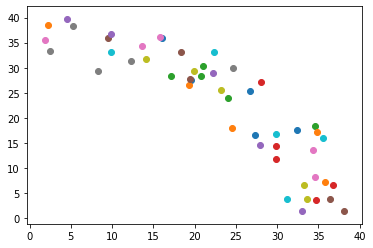

In [5]:
ICs = []
num_ics = 50
for i in range(0, num_ics):
    r = rd.uniform(30, 40)
    theta = rd.uniform(0, 1.57)
    ICs.append([r*np.cos(theta), r*np.sin(theta)])
    
for i in range(0, num_ics):
    plt.scatter(ICs[i][0],ICs[i][1])

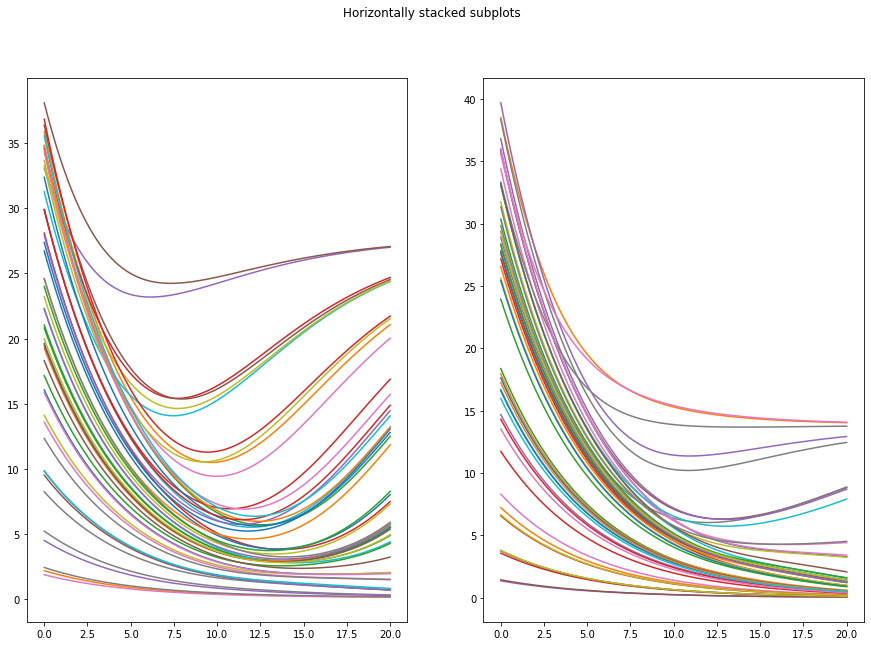

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Horizontally stacked subplots')
#ax1.plot(x, y)
#ax2.plot(x, -y)

Xp_final = np.array([[0, 0]])
Xf_final = np.array([[0, 0]])
for ic in ICs:
    yz_0 = np.array([ic[0], ic[1]])
    yz = scipy.integrate.odeint(toggle_switch, yz_0, t, args=args) 
    Xp = yz[0:-1]
    Xf = yz[1:]
    ax1.plot(t, np.array(yz).T[0])
    ax2.plot(t, np.array(yz).T[1])
    Xp_final = np.concatenate((Xp_final, Xp), axis=0)
    Xf_final = np.concatenate((Xf_final, Xf), axis=0)
    
Xp_final = Xp_final[1:]
Xf_final = Xf_final[1:]

## Discrete model

N = 20
Xp_final = []
Xf_final = []
t = np.array([i for i in range(0, N+1)])
x = np.zeros(2)
for ic in ICs:
    x[0] = ic[0]
    x[1] = ic[1]
    X = []
    X_actual = []
    X.append([x[0], x[1]])
    for k in range(0, N):
        y = model(x)
        x = y
        X.append([x[0], x[1]])
    Xp = X[0:-1]
    Xf = X[1:]
    plt.scatter(t, np.array(X).T[0])
    Xp_final.append(Xp)
    Xf_final.append(Xf)



N = 20
Xp_final = []
Xf_final = []
t = np.array([i for i in range(0, N+1)])
x = np.zeros(2)
for ic in ICs:
    x[0] = ic[0]
    x[1] = ic[1]
    X = []
    X_actual = []
    X.append([x[0], x[1]])
    for k in range(0, N):
        y = model(x)
        x = y
        X.append([x[0], x[1]])
    Xp = X[0:-1]
    Xf = X[1:]
    plt.scatter(t, np.array(X).T[1])
    Xp_final.append(Xp)
    Xf_final.append(Xf)



In [7]:
model_name = 'Toggle_Switch_DMJ'

['Checkpoint_files/Toggle_Switch_DMJ_scaler.save']

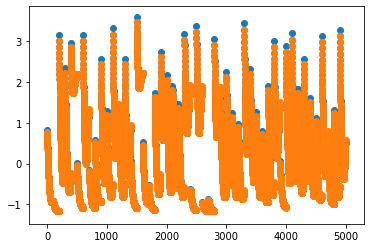

In [10]:
np.array(Xp_final).shape
states = 2

Xp_ref = np.array(Xp_final).reshape(num_ics*(n-1), states)
Xf_ref = np.array(Xf_final).reshape(num_ics*(n-1), states)
Up_ref = np.zeros(len(Xp_ref))

scaler = StandardScaler().fit(Xp_ref)
Xp_ref_scaled = scaler.transform(Xp_ref)
Xf_ref_scaled = scaler.transform(Xf_ref)

#pickle.dump([Xp_ref_scaled, Xf_ref_scaled, Up_ref], open('koopman_data/CFS_Koopman_correct_ics2.pickle', 'wb'),  protocol = 2)

pickle.dump([Xp_ref_scaled, Xf_ref_scaled, Up_ref], open('koopman_data/'+model_name+'.pickle', 'wb'),  protocol = 2)

plt.scatter(np.linspace(0, len(Xp_ref_scaled[:, 0]), len(Xp_ref_scaled[:, 0])), Xp_ref_scaled[:, 0])
plt.scatter(np.linspace(0, len(Xf_ref_scaled[:, 0]), len(Xf_ref_scaled[:, 0])), Xf_ref_scaled[:, 0])


P = np.diag(scaler.scale_)
b = scaler.mean_

scaler_filename = "Checkpoint_files/"+model_name+"_scaler.save"
joblib.dump(scaler, scaler_filename) 

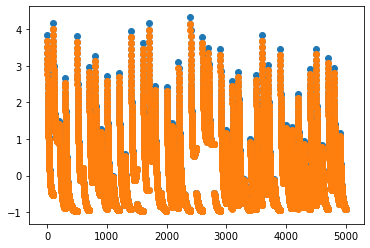

In [11]:
plt.scatter(np.linspace(0, len(Xp_ref_scaled[:, 1]), len(Xp_ref_scaled[:, 1])), Xp_ref_scaled[:, 1])
plt.scatter(np.linspace(0, len(Xf_ref_scaled[:, 1]), len(Xf_ref_scaled[:, 1])), Xf_ref_scaled[:, 1])
